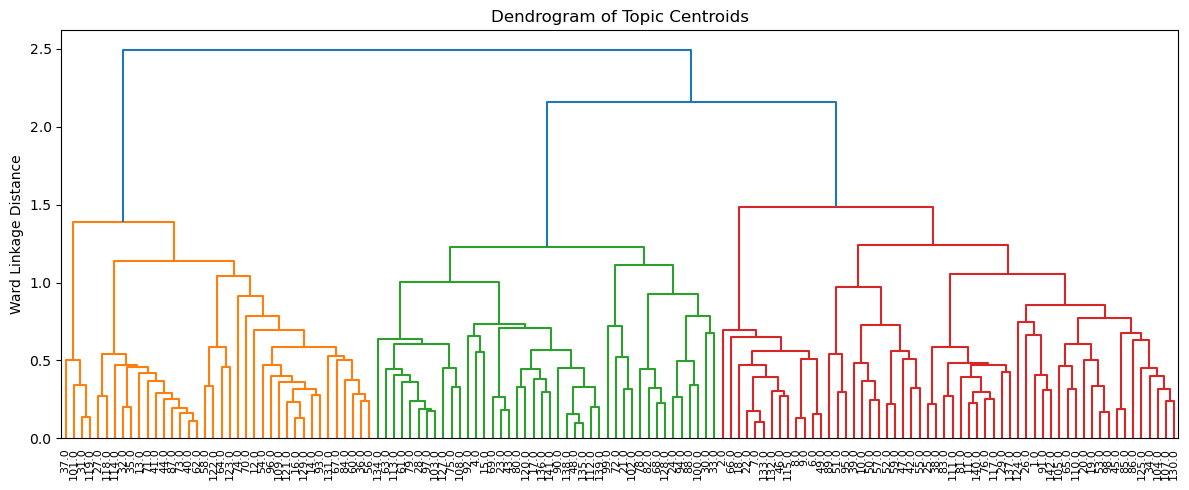

Cophenetic correlation coefficient: 1.482
Optimal K per criterion: {'elbow': 3, 'silhouette': 7, 'calinski_harabasz': 2, 'davies_bouldin': 14, 'dunn': 2}

=== Criterion: elbow, K = 3 ===
Number of topics per meta-cluster:
1    38
2    42
3    56


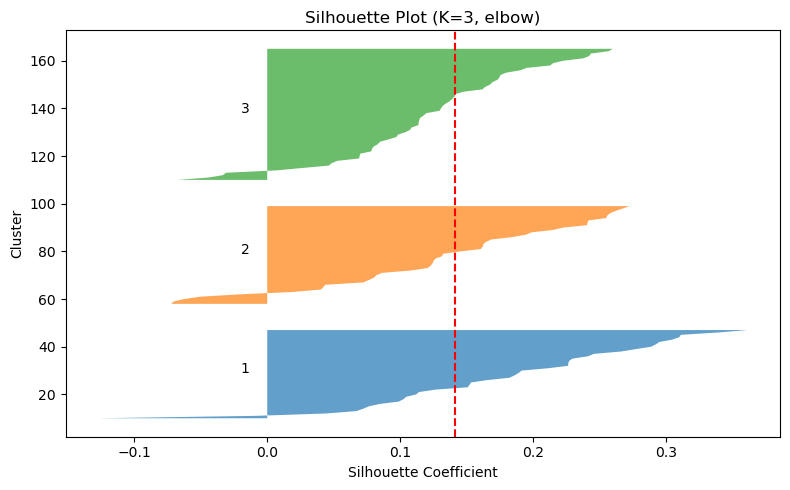

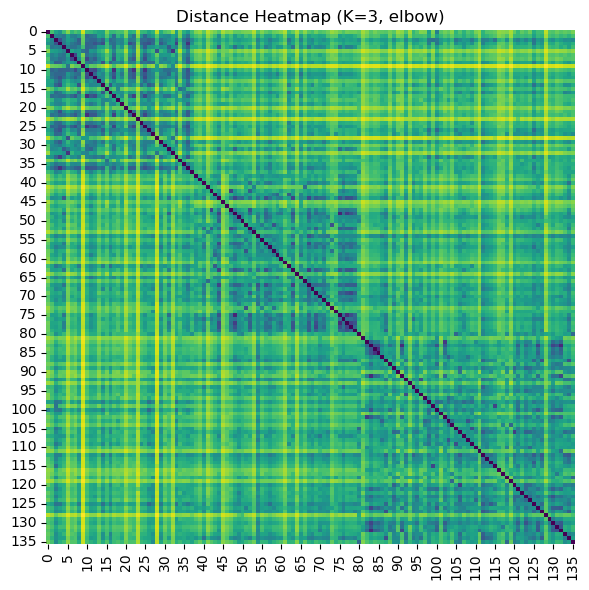

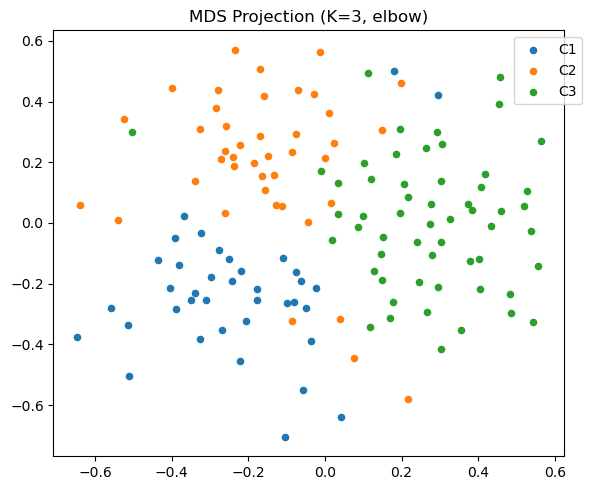


=== Criterion: silhouette, K = 7 ===
Number of topics per meta-cluster:
1     4
2    34
3    28
4    14
5    13
6    12
7    31


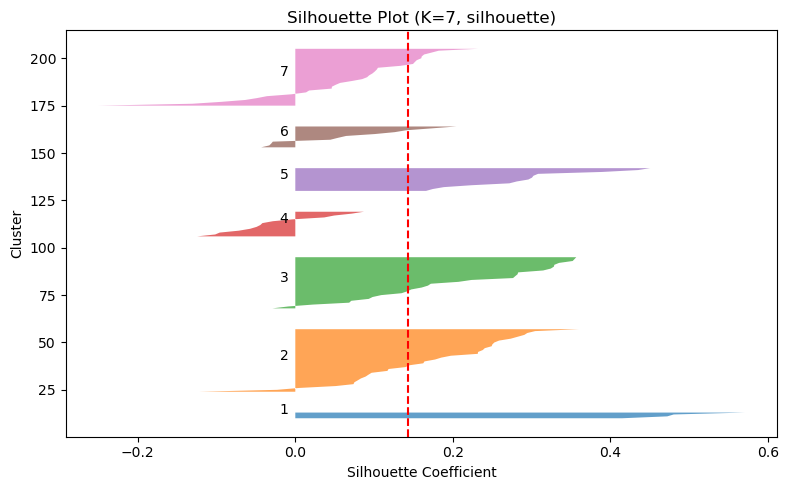

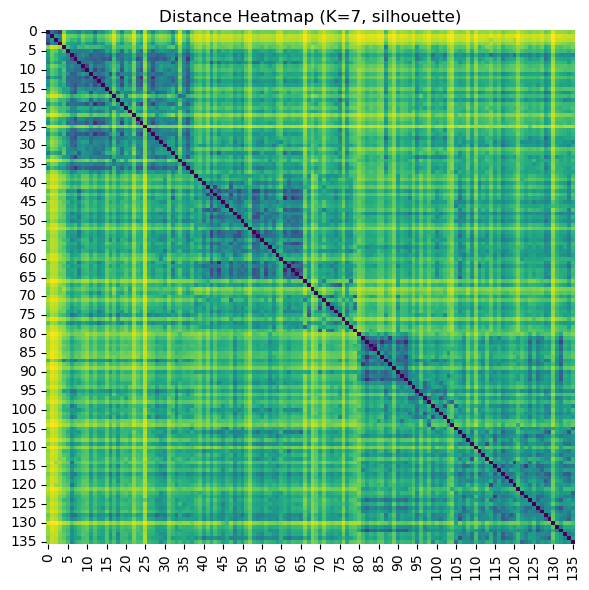

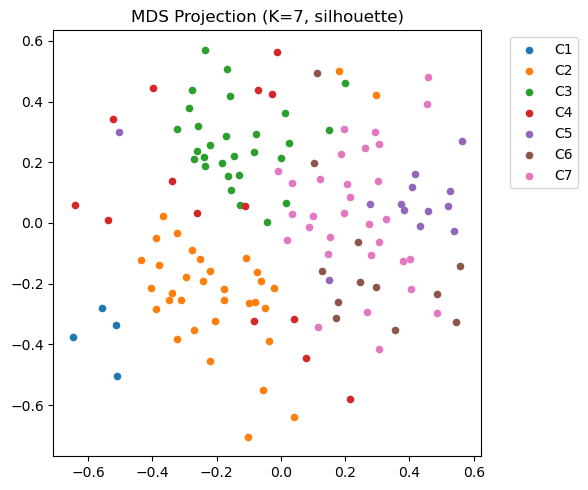


=== Criterion: calinski_harabasz, K = 2 ===
Number of topics per meta-cluster:
1    38
2    98


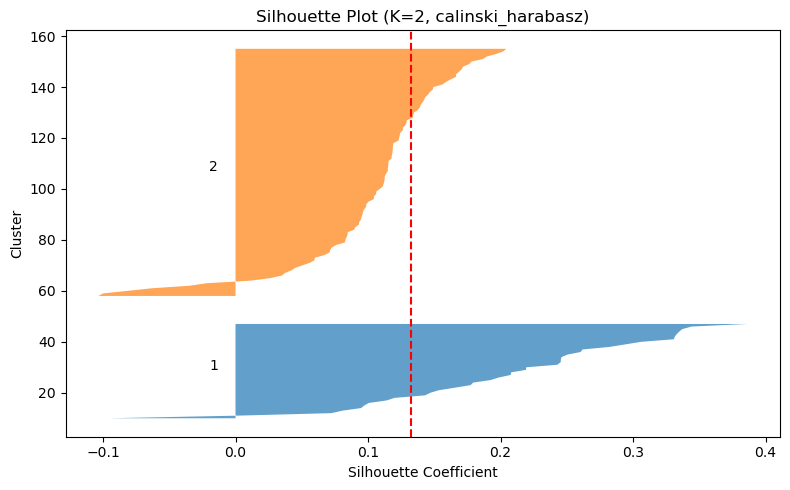

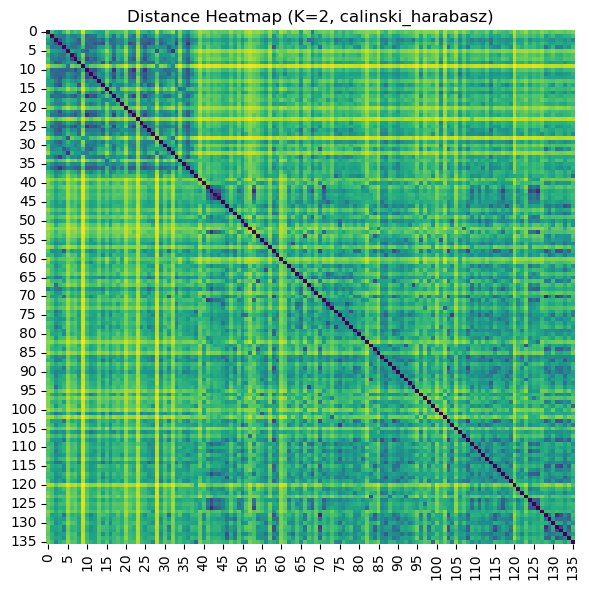

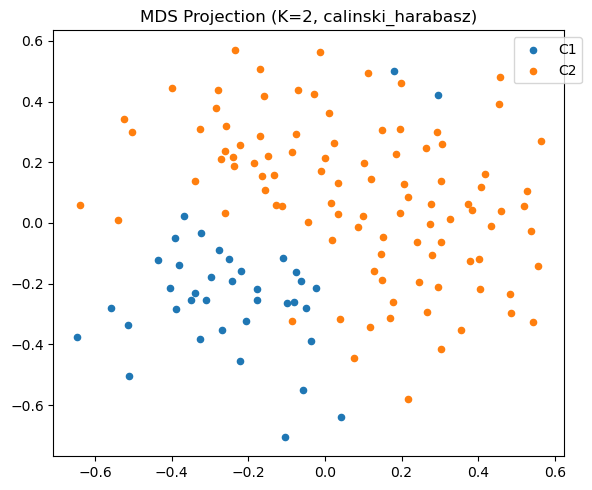


=== Criterion: davies_bouldin, K = 14 ===
Number of topics per meta-cluster:
1      4
2     13
3      4
4     17
5     11
6     17
7      4
8      4
9      6
10    13
11     3
12     9
13    11
14    20


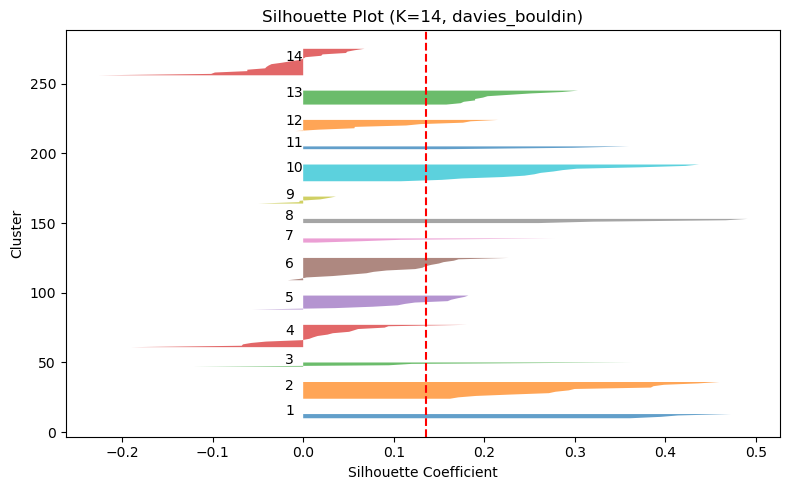

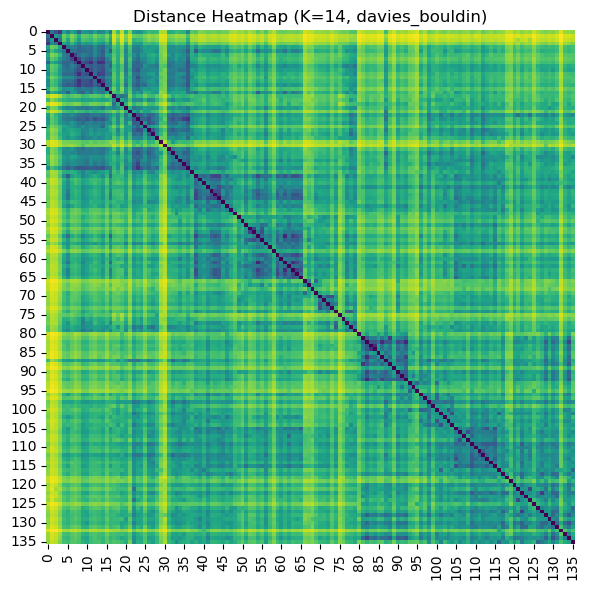

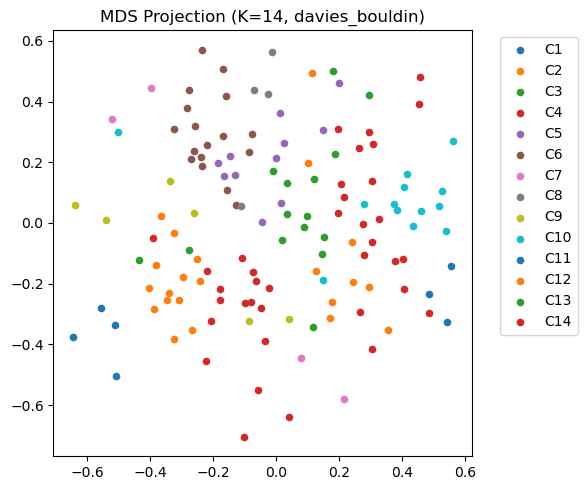


=== Criterion: dunn, K = 2 ===
Number of topics per meta-cluster:
1    38
2    98


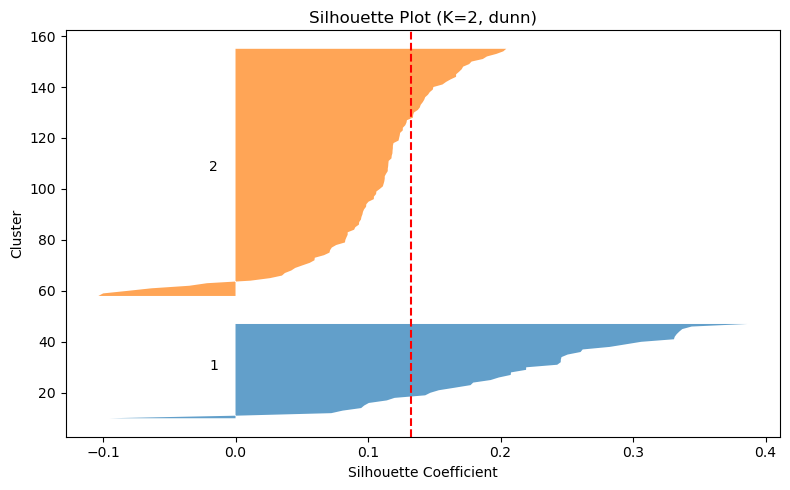

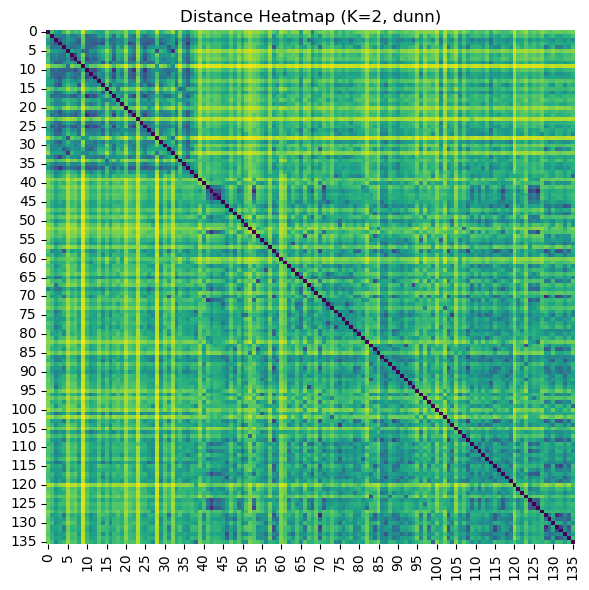

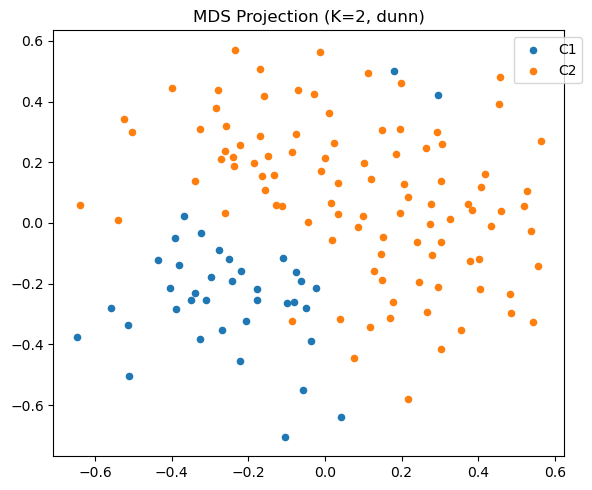


Sample df_m with all meta-topic assignments:


,REF impact case study identifier,merged,Assigned Topic,meta_topic_elbow,meta_topic_silhouette,meta_topic_calinski_harabasz,meta_topic_davies_bouldin,meta_topic_dunn
0,06b6214f-023c-4c3d-9357-d6e15df0bdf6,\n### 1. Summary of the impact \(indicative m...,142.0,3.0,7.0,2.0,14.0,2.0
1,69f8e156-791d-451e-bc6d-0d8a854eab5e,\n### 1. Summary of the impact \n\n Research ...,142.0,3.0,7.0,2.0,14.0,2.0
2,1b5a034e-88ca-4f09-af5c-b25eab8a2d62,\n### 1. Summary of the impact \(indicative m...,142.0,3.0,7.0,2.0,14.0,2.0
3,3cde462c-74cb-44c7-b60b-73ab3139d955,\n **1. Summary of the impact** \(indicative m...,142.0,3.0,7.0,2.0,14.0,2.0
4,db40ffee-0a07-4f54-9906-a9c455057221,\n1. **Summary of the impact** \(indicative m...,142.0,3.0,7.0,2.0,14.0,2.0


In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cophenet
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and merge data
df_re  = pd.read_excel('../data/reassignments/Reassignment.xlsx', sheet_name='ICSs')
df_raw = pd.read_excel('../data/raw/raw_ref_ics_data.xlsx')

cols = [
    '1. Summary of the impact',
    '2. Underpinning research',
    '3. References to the research',
    '4. Details of the impact',
    '5. Sources to corroborate the impact'
]
df_raw['merged'] = df_raw[cols].fillna('').agg(' '.join, axis=1)
df_m = pd.merge(df_re,
                df_raw[['REF impact case study identifier','merged']],
                on='REF impact case study identifier',
                how='left')

# 2. Compute TF-IDF vectors
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X = tfidf.fit_transform(df_m['merged'])
df_m['vec'] = list(X.toarray())

# 3. Compute topic centroids
centroids = df_m.groupby('Assigned Topic')['vec']\
    .apply(lambda vs: np.mean(np.vstack(vs), axis=0)).to_dict()
topic_ids = sorted(centroids.keys())
C = np.vstack([centroids[t] for t in topic_ids])

# 4. Hierarchical clustering
D_cond = pdist(C, metric='cosine')
D_sq   = squareform(D_cond)
Z      = linkage(D_cond, method='ward')

# 5. Static figures: Dendrogram and Cophenetic correlation
plt.figure(figsize=(12,5))
dendrogram(Z, labels=topic_ids, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Topic Centroids')
plt.ylabel('Ward Linkage Distance')
plt.tight_layout(); plt.show()

coph_dists, coph_corr = cophenet(Z, D_cond)
coph_corr = np.atleast_1d(coph_corr)[0]
print(f'Cophenetic correlation coefficient: {coph_corr:.3f}')

# 6. Compute validation metrics for K=2..15
Ks    = list(range(2, 15))
silhs, chs, dbs, dunns = [], [], [], []

def dunn_index(labels, D):
    clusters = np.unique(labels)
    diameters = [np.max(D[np.ix_(np.where(labels==c)[0], np.where(labels==c)[0])])
                 if np.sum(labels==c)>1 else 0 for c in clusters]
    seps = []
    for i, ci in enumerate(clusters):
        for cj in clusters[i+1:]:
            idx_i, idx_j = np.where(labels==ci)[0], np.where(labels==cj)[0]
            seps.append(np.min(D[np.ix_(idx_i, idx_j)]))
    return min(seps)/max(diameters) if max(diameters)>0 and seps else np.inf

for K in Ks:
    labs = fcluster(Z, t=K, criterion='maxclust')
    silhs.append(silhouette_score(C, labs, metric='cosine'))
    chs.append(calinski_harabasz_score(C, labs))
    dbs.append(davies_bouldin_score(C, labs))
    dunns.append(dunn_index(labs, D_sq))

# 7. Determine best K for each criterion
best = {
    'elbow': None,
    'silhouette': Ks[int(np.argmax(silhs))],
    'calinski_harabasz': Ks[int(np.argmax(chs))],
    'davies_bouldin': Ks[int(np.argmin(dbs))],
    'dunn': Ks[int(np.argmax(dunns))]
}
jumps = Z[:,2][1:] - Z[:,2][:-1]
best['elbow'] = len(topic_ids) - (np.argmax(jumps)+1)

print("Optimal K per criterion:", best)

# 8. Loop through criteria and plot cluster-specific figures
for name, K in best.items():
    print(f"\n=== Criterion: {name}, K = {K} ===")
    labels = fcluster(Z, t=K, criterion='maxclust')
    
    # Cluster size (# of topics)
    mapping = dict(zip(topic_ids, labels))
    topic_counts = pd.Series(mapping).value_counts().sort_index()
    print("Number of topics per meta-cluster:")
    print(topic_counts.to_string())
    
    # Silhouette plot
    sil_vals = silhouette_samples(C, labels, metric='cosine')
    y_low = 10
    plt.figure(figsize=(8,5))
    for c in np.unique(labels):
        vals = np.sort(sil_vals[labels==c])
        y_high = y_low + len(vals)
        plt.fill_betweenx(np.arange(y_low, y_high), 0, vals, alpha=0.7)
        plt.text(-0.02, y_low + 0.5*len(vals), str(c))
        y_low = y_high + 10
    plt.axvline(np.mean(sil_vals), color='red', linestyle='--')
    plt.title(f'Silhouette Plot (K={K}, {name})')
    plt.xlabel('Silhouette Coefficient'); plt.ylabel('Cluster')
    plt.tight_layout(); plt.show()
    
    # Heatmap of distances
    order = [t for _,t in sorted(zip(labels, topic_ids))]
    idx_order = [topic_ids.index(t) for t in order]
    D_ord = D_sq[np.ix_(idx_order, idx_order)]
    plt.figure(figsize=(6,6))
    sns.heatmap(D_ord, cmap='viridis', cbar=False)
    plt.title(f'Distance Heatmap (K={K}, {name})')
    plt.tight_layout(); plt.show()
    
    # MDS projection
    coords = MDS(n_components=2, dissimilarity='precomputed', random_state=0)\
             .fit_transform(D_sq)
    plt.figure(figsize=(6,5))
    for c in np.unique(labels):
        idx = labels==c
        plt.scatter(coords[idx,0], coords[idx,1], label=f'C{c}', s=20)
    plt.legend(bbox_to_anchor=(1.05,1))
    plt.title(f'MDS Projection (K={K}, {name})')
    plt.tight_layout(); plt.show()
    
    # Append labels to df_m
    df_m[f'meta_topic_{name}'] = df_m['Assigned Topic'].map(mapping)

# 9. Preview merged df_m with appended meta-topic columns
cols_show = ['REF impact case study identifier','merged','Assigned Topic'] + [f'meta_topic_{n}' for n in best]
print("\nSample df_m with all meta-topic assignments:")
display(df_m[cols_show].head())

df_m.to_csv('../data/clustering_themes/hierarchy.csv')

In [2]:
import pandas as pd
import numpy as np

# --- assume you have already ---
# Z: the (n−1)×4 linkage matrix from scipy.cluster.hierarchy.linkage
# topic_ids: a list of length n of your topic labels, in the order used to compute Z

n = len(topic_ids)

# initialize a map from the 0…n−1 leaf indices to their labels
labels = {i: str(topic_ids[i]) for i in range(n)}

rows = []
for step, (i1, i2, dist, cnt) in enumerate(Z, start=1):
    i1, i2 = int(i1), int(i2)
    lab1 = labels[i1]
    lab2 = labels[i2]
    # define the new cluster’s label as the fusion of its two children
    new_lab = f"({lab1} + {lab2})"
    # the new cluster’s integer index in SciPy’s scheme is n + (step−1)
    new_idx = n + (step - 1)
    labels[new_idx] = new_lab

    rows.append({
        'step':           step,
        'cluster1_id':    i1,
        'cluster1_label': lab1,
        'cluster2_id':    i2,
        'cluster2_label': lab2,
        'distance':       dist,
        'cluster_size':   int(cnt),
        'new_cluster_label': new_lab
    })

# build the DataFrame
df_linkage = pd.DataFrame(rows)

# save to Excel (or use .to_csv if you prefer CSV)
df_linkage.to_excel('../data/clustering_themes/dendrogram_structure.xlsx', index=False)

# (optional) display the first few rows to verify
print(df_linkage.head(50))


    step  cluster1_id            cluster1_label  cluster2_id  \
0      1           45                      48.0          128   
1      2            4                       7.0          126   
2      3           37                      40.0           59   
3      4            5                       8.0            6   
4      5           13                      16.0          122   
5      6           28                      31.0          113   
6      7            3                       6.0           46   
7      8          131                     138.0          136   
8      9           70                      73.0          138   
9     10           50                      53.0           94   
10    11           93                      97.0           99   
11    12           19                      22.0          137   
12    13           20                      23.0           40   
13    14           25                      28.0          146   
14    15           42                   